In [2]:
pip install --upgrade bottleneck



  Attempting uninstall: bottleneck
    Found existing installation: Bottleneck 1.3.5
    Uninstalling Bottleneck-1.3.5:
      Successfully uninstalled Bottleneck-1.3.5


In [9]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.optimizers import Adam

# Use tensorflow.keras instead of keras
from tensorflow.keras.utils import to_categorical  # Correct import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Reshape, LSTM
from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [12]:
for dirname, _, filenames in os.walk(r'C:\Users\Dharm\Downloads\archive (1)'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\Dharm\Downloads\archive (1)\HAM10000_metadata.csv
C:\Users\Dharm\Downloads\archive (1)\hmnist_28_28_L.csv
C:\Users\Dharm\Downloads\archive (1)\hmnist_28_28_RGB.csv
C:\Users\Dharm\Downloads\archive (1)\hmnist_8_8_L.csv
C:\Users\Dharm\Downloads\archive (1)\hmnist_8_8_RGB.csv
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0024306.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0024307.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0024308.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0024309.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0024310.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0024311.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0024312.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0024313.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0024314.jpg
C:\Users\Dharm\Downloads

C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029306.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029307.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029308.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029309.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029310.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029311.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029312.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029313.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029314.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029315.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029316.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029317.jpg
C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_2\ISIC_0029318.jpg

In [15]:
base_skin_dir = os.path.join('..', r'C:\Users\Dharm\Downloads\archive (1)')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [16]:
skin_df = pd.read_csv(r'C:\Users\Dharm\Downloads\archive (1)\HAM10000_metadata.csv')
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [17]:
skin_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1331,HAM_0005588,ISIC_0025219,mel,histo,80.0,female,lower extremity,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Melanoma,5
4788,HAM_0005895,ISIC_0032252,nv,follow_up,45.0,female,back,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Melanocytic nevi,4
8086,HAM_0000279,ISIC_0032375,nv,histo,40.0,female,trunk,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Melanocytic nevi,4
184,HAM_0002008,ISIC_0032983,bkl,histo,60.0,female,face,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Benign keratosis-like lesions,2
6090,HAM_0001056,ISIC_0025329,nv,follow_up,25.0,male,trunk,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Melanocytic nevi,4
8798,HAM_0002423,ISIC_0028963,nv,histo,30.0,female,abdomen,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Melanocytic nevi,4
289,HAM_0006128,ISIC_0028701,bkl,histo,55.0,female,lower extremity,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Benign keratosis-like lesions,2
1310,HAM_0001353,ISIC_0030759,mel,histo,55.0,female,face,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Melanoma,5
1399,HAM_0007117,ISIC_0033312,mel,histo,35.0,male,back,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Melanoma,5
6576,HAM_0006701,ISIC_0029310,nv,follow_up,40.0,female,foot,C:\Users\Dharm\Downloads\archive (1)\HAM10000_...,Melanocytic nevi,4


In [21]:
skin_df['age'] = skin_df['age'].fillna(skin_df['age'].mean())


In [23]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

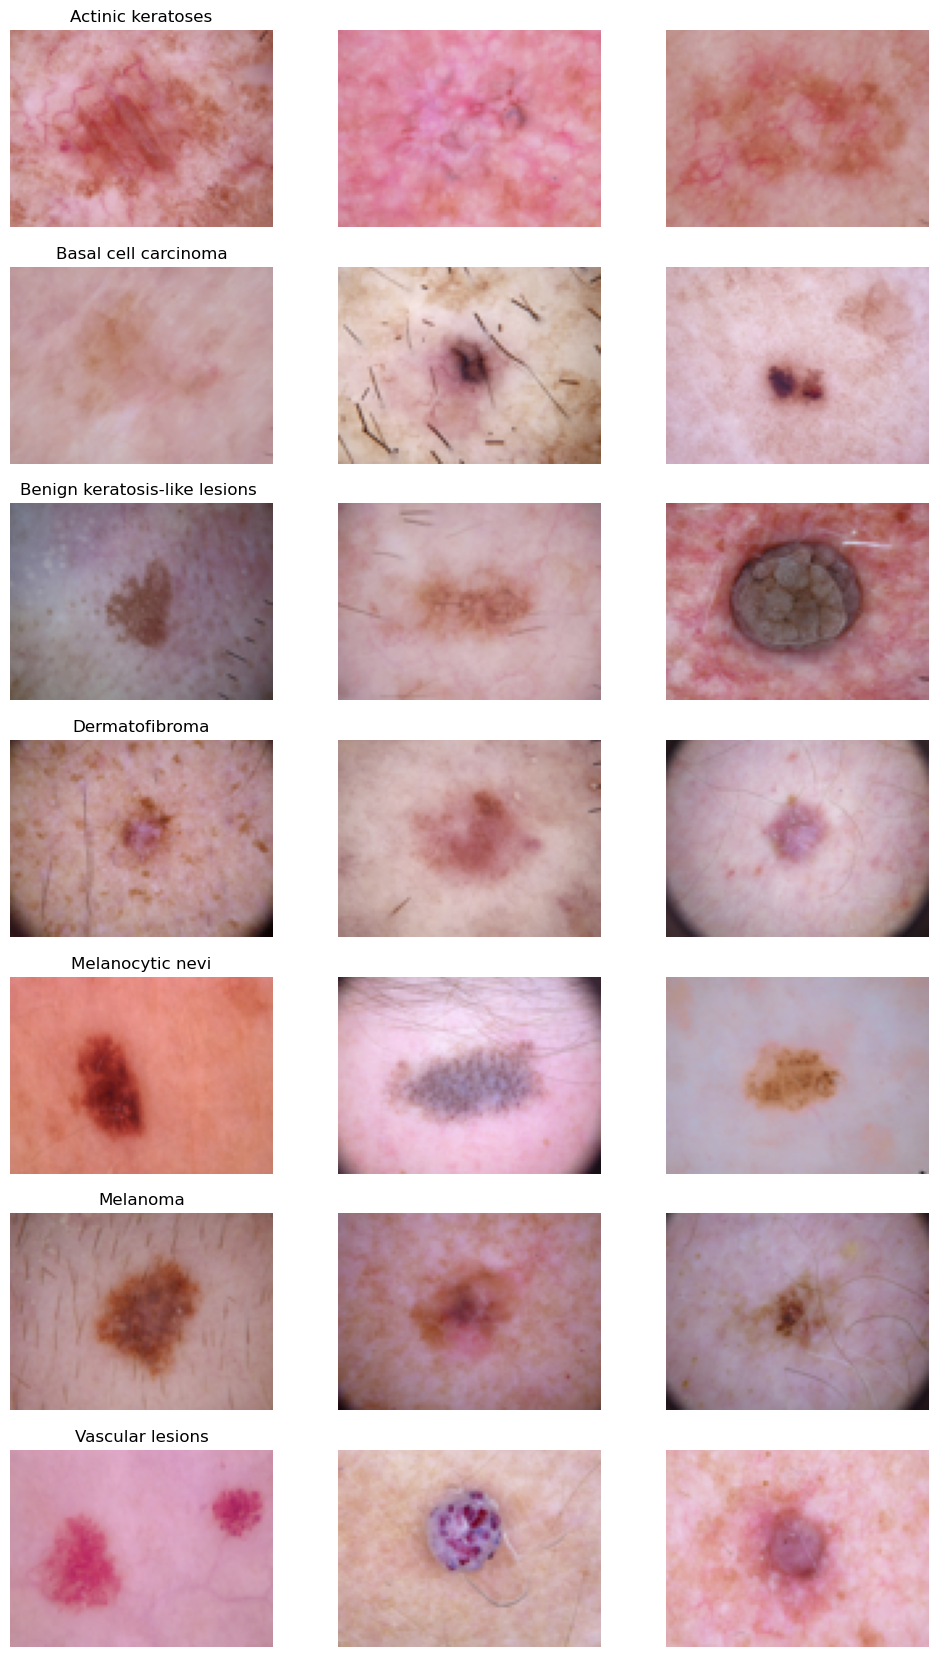

In [24]:
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [25]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [26]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=23)

In [27]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [28]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [29]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 23)

In [30]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  

datagen.fit(x_train)

CNN model

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input

# Define input shape and number of classes
input_shape = (75, 100, 3)
num_classes = 7

# Create the model
model = Sequential()

# Use Input layer to define the input shape
model.add(Input(shape=input_shape))

# Add convolutional layers
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))




In [42]:
# Define the optimizer without the decay parameter
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [43]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 75, 100, 64)         │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 75, 100, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 75, 100, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 75, 100, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 37, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 37, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 37, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 37, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 37, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 37, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 18, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 18, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 18, 25, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 18, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 18, 25, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 9, 12, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 9, 12, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 27648)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,310,919 (58.41 MB)

 Trainable params: 15,308,103 (58.40 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [44]:
'''learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)'''

In [45]:
'''early_stop = EarlyStopping(monitor='val_loss', patience=6)
mod_chckpt = ModelCheckpoint(filepath='model_v1_rms.keras', monitor='val_loss', save_best_only=True)'''


In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Assuming you have already defined datagen, x_train, y_train, x_validate, y_validate

epochs = 10
batch_size = 50

# Compile the model before fitting (ensure you've defined the optimizer and loss function)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience=4, 
                                         verbose=1, 
                                         factor=0.5, 
                                         min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=6)
mod_chckpt = ModelCheckpoint(filepath='model_v1_rms.keras', monitor='val_loss', save_best_only=True)

# Fit the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_validate, y_validate),
                    verbose=1,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction, early_stop, mod_chckpt])

# Example of getting a batch of data (if needed)
batch_x, batch_y = next(datagen.flow(x_train, y_train, batch_size=batch_size))
print(f"Batch x shape: {batch_x.shape}, Batch y shape: {batch_y.shape}")

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - accuracy: 0.5269 - loss: 1.9598 - val_accuracy: 0.6409 - val_loss: 1.0307 - learning_rate: 0.0010
Epoch 2/10
  1/144 ━━━━━━━━━━━━━━━━━━━━ 6:27 3s/step - accuracy: 0.6200 - loss: 1.0115

D:\anaconda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.6200 - loss: 1.0115 - val_accuracy: 0.6446 - val_loss: 1.0204 - learning_rate: 0.0010
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.7077 - loss: 0.8312 - val_accuracy: 0.6584 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.6800 - loss: 0.8762 - val_accuracy: 0.6608 - val_loss: 1.0559 - learning_rate: 0.0010
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.7118 - loss: 0.7814 - val_accuracy: 0.6658 - val_loss: 0.9796 - learning_rate: 0.0010
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8000 - loss: 0.7345 - val_accuracy: 0.6658 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.7294 - loss: 0.7425 - val_accuracy: 0.7095 - val_loss: 0.8366 - learning_rate: 0.0010
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8600 - loss: 0.4887 - 

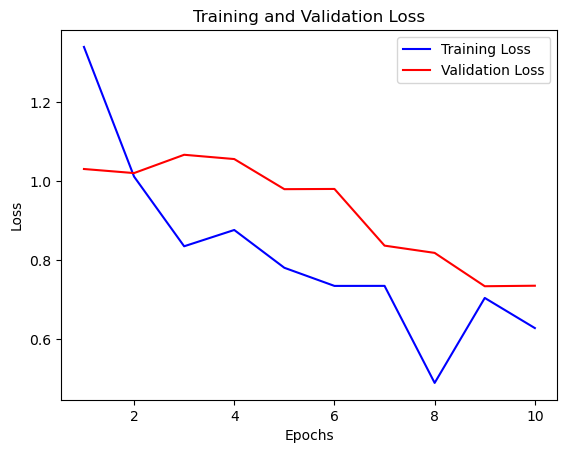

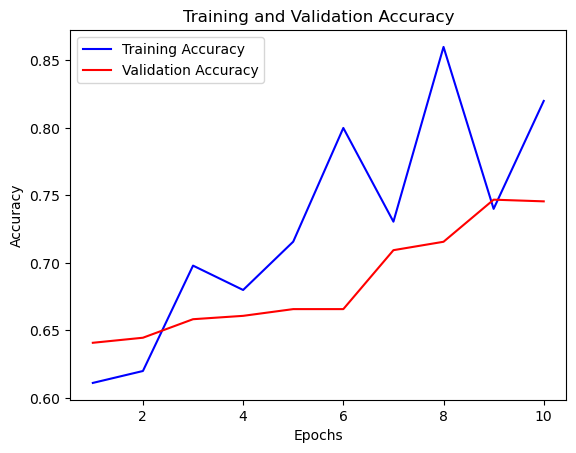

In [67]:
history_dict = history.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss_value) + 1)
plt.plot(epochs, loss_value, 'b', label='Training Loss')
plt.plot(epochs, val_loss_value, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_adam.png')
plt.show()

plt.figure()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_adam.png')
plt.show()

In [69]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save('adam_model.keras')

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.7210 - loss: 0.7506
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 352ms/step - accuracy: 0.7571 - loss: 0.6847
Validation: accuracy = 0.745636  ;  loss_v = 0.734994
Test: accuracy = 0.736395  ;  loss = 0.725242


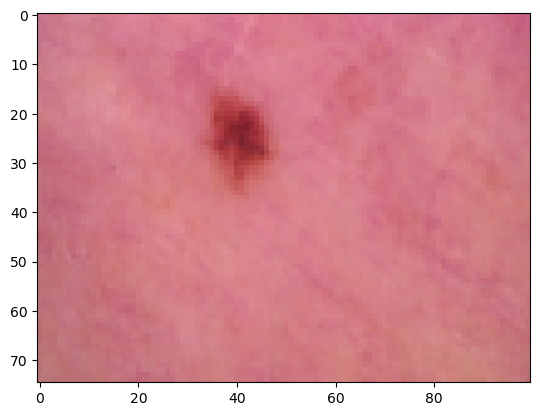

In [70]:
plt.imshow(((x_test[5]*x_test_std)+x_test_mean).astype('int'))

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step


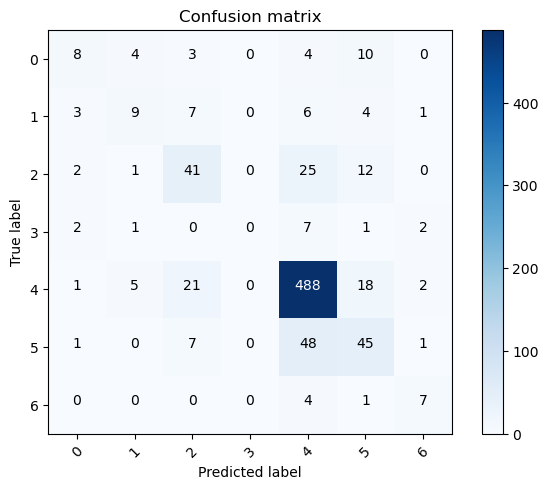

In [71]:
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

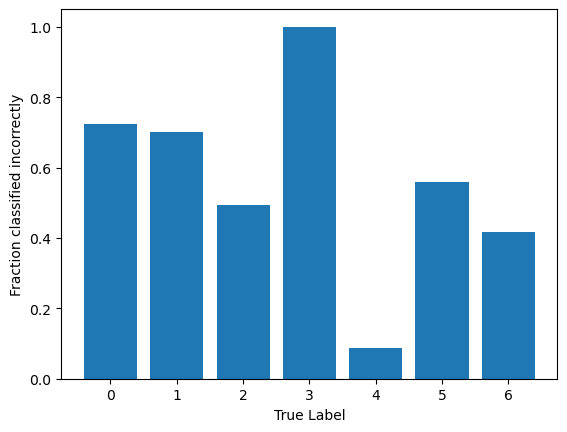

In [72]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

CNN+LSTM model

In [74]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input, LSTM, Reshape

# Define input shape and number of classes
input_shape = (75, 100, 3)  # Assuming RGB images
num_classes = 7

# Create the model
model2 = Sequential()

# Input layer
model2.add(Input(shape=input_shape))

# Convolutional Layers
model2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

# Flatten and LSTM layer (consider removing or replacing)
model2.add(Flatten())
model2.add(Reshape((9 * 16, 192)))  # Reshape for LSTM (might not be suitable for images)
model2.add(LSTM(units=32))

# Dense layers
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(num_classes, activation='softmax'))

In [77]:
optimizer2 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None,amsgrad=False)
model2.compile(optimizer = optimizer2 , loss = "categorical_crossentropy", metrics=["accuracy"])

In [84]:
epochs = 3
batch_size = 50
history2 = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_validate, y_validate),
                    verbose=1,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction, early_stop, mod_chckpt])


Epoch 1/3
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.7589 - loss: 0.6610 - val_accuracy: 0.6796 - val_loss: 0.8550 - learning_rate: 0.0010
Epoch 2/3
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6600 - loss: 0.8033 - val_accuracy: 0.6820 - val_loss: 0.8277 - learning_rate: 0.0010
Epoch 3/3
144/144 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.7747 - loss: 0.6000 - val_accuracy: 0.6983 - val_loss: 0.8832 - learning_rate: 0.0010


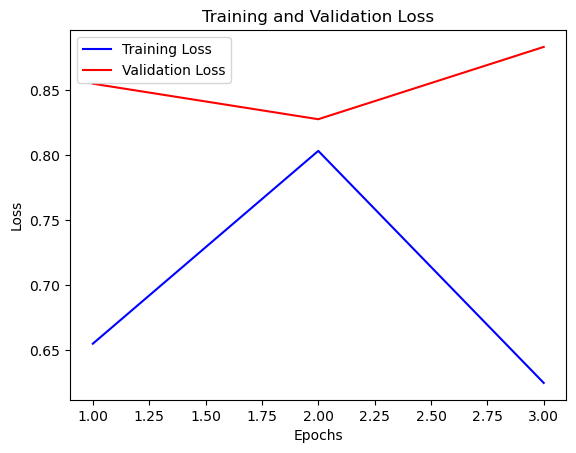

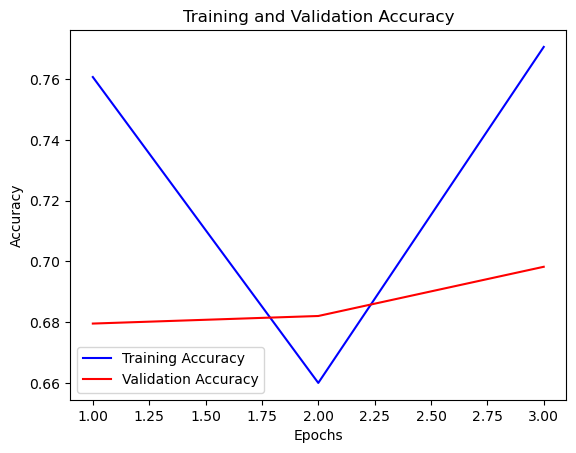

In [85]:
history_dict = history2.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss_value) + 1)
plt.plot(epochs, loss_value, 'b', label='Training Loss')
plt.plot(epochs, val_loss_value, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_lstm.png')
plt.show()

plt.figure()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_lstm.png')
plt.show()

In [87]:
loss, accuracy = model2.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model2.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save('lstm_model.keras')

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.0602 - loss: 1.9354
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - accuracy: 0.0363 - loss: 1.9364
Validation: accuracy = 0.043641  ;  loss_v = 1.936802
Test: accuracy = 0.057414  ;  loss = 1.935188


In [89]:
print(f"Predicted {np.argmax(model2.predict(x_test[1].reshape(-1,75,100,3)))}\nActual {np.argmax(y_test[1])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted 1
Actual 4


In [99]:
pip install opencv-python


   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   -- ------------------------------------- 2.6/38.8 MB 16.9 MB/s eta 0:00:03
   ---- ----------------------------------- 4.7/38.8 MB 12.4 MB/s eta 0:00:03
   ----- ---------------------------------- 5.8/38.8 MB 9.8 MB/s eta 0:00:04
   ------ --------------------------------- 6.6/38.8 MB 8.4 MB/s eta 0:00:04
   ------- -------------------------------- 7.6/38.8 MB 7.7 MB/s eta 0:00:05
   -------- ------------------------------- 8.1/38.8 MB 6.9 MB/s eta 0:00:05
   -------- ------------------------------- 8.7/38.8 MB 6.2 MB/s eta 0:00:05
   --------- ------------------------------ 9.2/38.8 MB 5.6 MB/s eta 0:00:06
   --------- ------------------------------ 9.7/38.8 MB 5.3 MB/s eta 0:00:06
   ---------- ----------------------------- 10.2/38.8 MB 5.1 MB/s eta 0:00:06
   ----------- ---------------------------- 10.7/38.8 MB 4.9 MB/s eta 0:00:06
   ----------- ---------------------------- 11.5/38.8 MB 4.7 MB/s eta 0:00:06


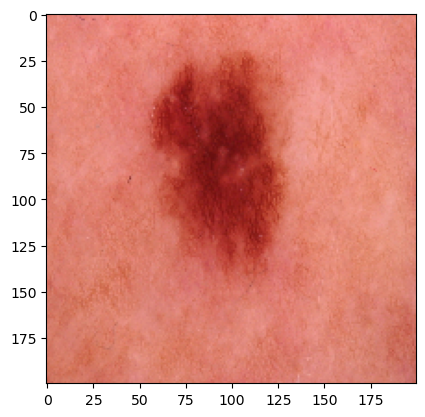

Prediction: Melanocytic nevi


In [102]:

from skimage import io
from keras.preprocessing import image
import cv2  # If 'color_mode' is not available

img_path = r'C:\Users\Dharm\Downloads\archive (1)\HAM10000_images_part_1\ISIC_0026899.jpg'

# Using 'color_mode' (if supported)
# img = image.load_img(img_path, color_mode='grayscale', target_size=(64, 64)) 

# Using OpenCV for grayscale conversion
img = image.load_img(img_path, target_size=(64, 64)) 
img_array = image.img_to_array(img) 
gray_img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY) 

show_img = image.load_img(img_path, target_size=(200, 200)) 

plt.imshow(show_img)
plt.show()

disease_class = [ 'Melanocytic nevi','Melanoma','Benign keratosis-like lesions ','Basal cell carcinoma','Actinic keratoses','Vascular lesions','Dermatofibroma']
print('Prediction:',disease_class[ind])